# Downsample & mix

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [4]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [5]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [6]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [7]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [80]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


,file,modification,cell,replicate,peaks,tool,dataset
74,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,GM12878,rep1,1741,MACS2,ENCODE
219,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me3,HepG2,rep2,30452,SICER,ENCODE
262,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,Huvec,rep2,38589,SPAN,ENCODE
166,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,H1,rep2,15228,MACS2 broad,ENCODE
55,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me1,K562,rep2,55038,MACS2,ENCODE


In [81]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


,file,modification,cell,replicate,peaks,tool,dataset
33,/home/jetbrains/data/2023_Immune/macs2/NK_H3K4...,H3K4me3,NK,,131599,MACS2,Roadmap
63,/home/jetbrains/data/2023_Immune/macs2/CD34_H3...,H3K27ac,CD34,,79969,MACS2 broad,Roadmap
53,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K4me1,BCell,,127965,MACS2 broad,Roadmap
88,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K4me1,TCell,,145437,MACS2 broad,Roadmap
79,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K36me3,BCell,,152502,MACS2 broad,Roadmap


In [82]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)
OUTLIERS = [('H3K4me3', 'NK', ''), ('H3K4me1', 'NK', ''), ('H3K27me3', 'TCell', ''), 
            ('H3K27ac', 'CD34', ''), ('H3K27me3', 'NHLF', 'rep2'), ('H3K27me3', 'GM12878', 'rep1')]
# Remove outliers
# display(df_peaks[(df_peaks['peaks'] > 130_000) | (df_peaks['peaks'] < 10_000)])
# df_peaks = df_peaks[(df_peaks['peaks'] < 130_000) & (df_peaks['peaks'] > 10_000)]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

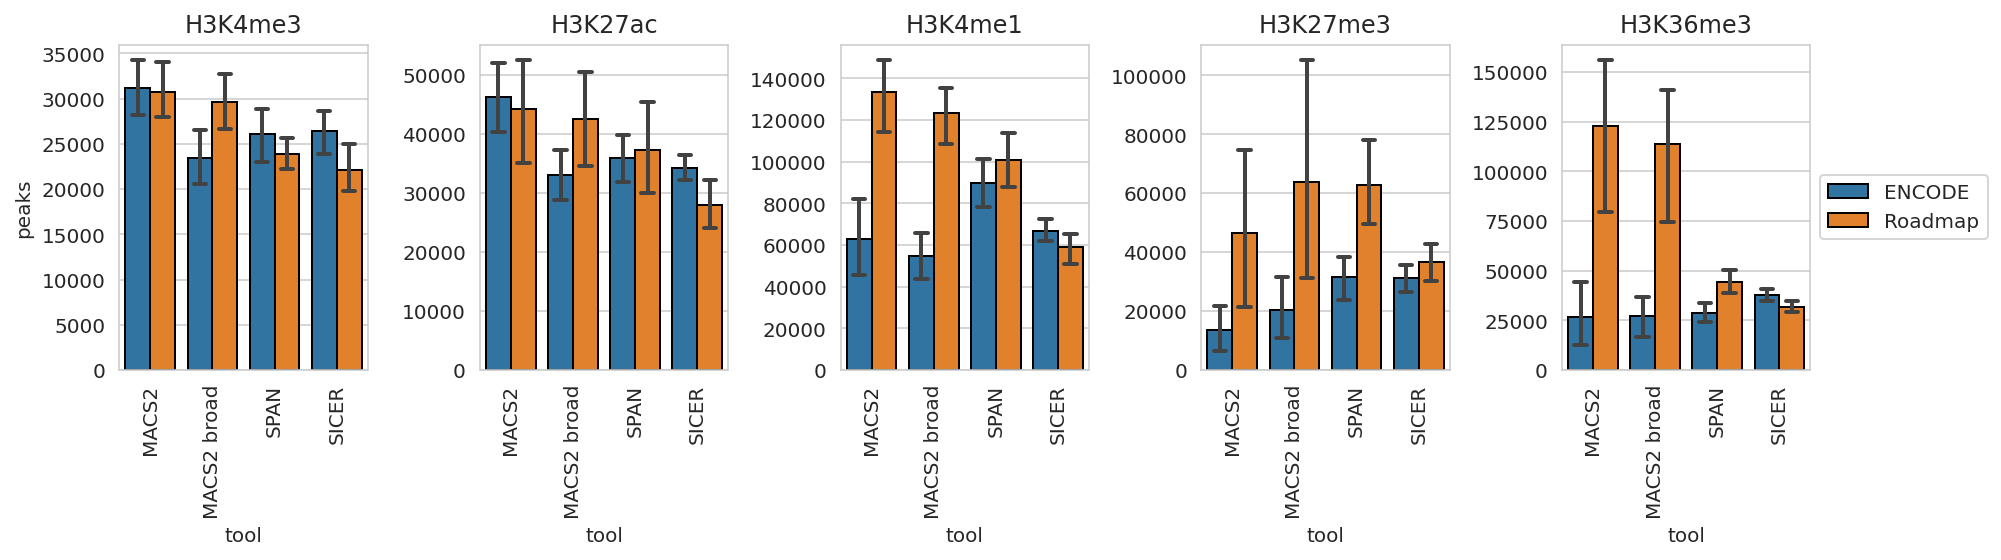

In [13]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Compute BAM coverage

In [35]:
def load_bams(path, modifications, cells, replicates, control='Input', counts=False):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            if counts:
                reads = ! samtools view -F 0x04 -c {file}
                reads = int(reads[0])
            else:
                reads = None
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [36]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams

  0%|          | 0/206 [00:00<?, ?it/s]

,bam_file,modification,cell,replicate,reads,dataset
0,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K36me3,NHLF,rep1,None,ENCODE
1,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K36me3,NHEK,rep2,None,ENCODE
2,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,NHEK,rep1,None,ENCODE
3,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27me3,HSMM,rep2,None,ENCODE
4,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,K562,rep2,None,ENCODE
...,...,...,...,...,...,...
98,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,GM12878,rep1,None,ENCODE
99,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me3,NHEK,rep1,None,ENCODE
100,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,H1,rep2,None,ENCODE
101,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,HSMM,rep2,None,ENCODE


In [37]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams

  0%|          | 0/113 [00:00<?, ?it/s]

,bam_file,modification,cell,replicate,reads,dataset
0,/home/jetbrains/data/2023_Immune/bams/CD4ABT_C...,Control,CD4ABT,rep2,None,Roadmap
1,/home/jetbrains/data/2023_Immune/bams/CD4_Cont...,Control,CD4,,None,Roadmap
2,/home/jetbrains/data/2023_Immune/bams/TCell_Co...,Control,TCell,,None,Roadmap
3,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K4me3,CD34,rep2,None,Roadmap
4,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K27me3,CD34,,None,Roadmap
5,/home/jetbrains/data/2023_Immune/bams/NK_H3K4m...,H3K4me1,NK,,None,Roadmap
6,/home/jetbrains/data/2023_Immune/bams/CD4_H3K4...,H3K4me1,CD4,,None,Roadmap
7,/home/jetbrains/data/2023_Immune/bams/BCell_H3...,H3K27ac,BCell,,None,Roadmap
8,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K27me3,CD34,rep2,None,Roadmap
9,/home/jetbrains/data/2023_Immune/bams/CD4_H3K2...,H3K27ac,CD4,,None,Roadmap


In [38]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)
df_bams = df_bams.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_bams[['modification', 'cell', 'replicate']].iterrows()]].copy()

In [ ]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams,
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.05, errwidth=2, edgecolor="black",
                        hue_order=MODIFICATIONS+['Control']
                        )
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## Prepare BAM -> BED files limited on chr1 

In [153]:
df_bam_beds = df_bams[df_bams['modification'] != 'Control'].copy()

In [117]:
DOWNSAMPLE_DIR = os.path.expanduser('~/data/2023_downsample')
DOWNSAMPLE_FRACTIONS = [0.7, 0.5, 0.2, 0.1]

In [156]:
! mkdir -p {DOWNSAMPLE_DIR}/bed

beds = []
for _, (c, bam_file) in tqdm(df_bam_beds[['cell', 'bam_file']].iterrows()):
    bed_file = f'{DOWNSAMPLE_DIR}/bed/{os.path.basename(bam_file).replace(".bam", "_chr1.bed")}'
    # Limit cells
    if c not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
        beds.append(bed_file)
        continue
    print(bed_file)
    beds.append(bed_file)
    tab = '\t'
    if not os.path.exists(bed_file):
        ! bamToBed -i {bam_file} | grep "chr1{tab}" > {bed_file}
df_bam_beds['bed_file'] = beds
df_bam_beds.sample(3)

0it [00:00, ?it/s]

/home/jetbrains/data/2023_downsample/bed/GSM646441_K562_H3K4me1_rep2_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646445_K562_H3K4me3_rep2_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646418_Huvec_H3K36me3_rep1_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646322_GM12878_H3K4me1_rep1_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646414_Huvec_H3K27ac_rep1_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646317_GM12878_H3K27ac_rep2_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646415_Huvec_H3K27ac_rep2_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646444_K562_H3K4me3_rep1_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646437_K562_H3K27me3_rep2_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646320_GM12878_H3K36me3_rep1_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646440_K562_H3K4me1_rep1_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM646421_Huvec_H3K4me1_rep2_chr1.bed
/home/jetbrains/data/2023_downsample/bed/GSM6464

,bam_file,modification,cell,replicate,reads,dataset,bed_file
45,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27me3,H1,rep1,None,ENCODE,/home/jetbrains/data/2023_downsample/bed/GSM64...
124,/home/jetbrains/data/2023_Immune/bams/BCell_H3...,H3K36me3,BCell,,None,Roadmap,/home/jetbrains/data/2023_downsample/bed/BCell...
85,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me3,H1,rep2,None,ENCODE,/home/jetbrains/data/2023_downsample/bed/GSM64...


# Downsample

In [128]:
! mkdir -p {DOWNSAMPLE_DIR}/bams

tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
tf3 = tempfile.mktemp()
tf4 = tempfile.mktemp()

downsampled = []
for _, (ds, m, c, r, bam_file, bed_file) in tqdm(
        df_bam_beds[['dataset', 'modification', 'cell', 'replicate', 'bam_file', 'bed_file']].iterrows()):
    print(ds, m, c, r)
    for fraction in DOWNSAMPLE_FRACTIONS:
        print(fraction)
        result_file = f'{DOWNSAMPLE_DIR}/bams/{m}_{c}_{r}_{fraction}.bam'
        print(result_file)
        downsampled.append((ds, m, c, r, fraction, result_file))
        if os.path.exists(result_file):
            continue
        signal = pd.read_csv(bed_file, sep='\t', header=None)
        signal_reads = len(signal)
        print('Signal', bed_file, signal_reads)
        signal = signal.sample(int(signal_reads * fraction))
        signal.to_csv(tf1, sep='\t', index=False, header=None)
        ! cat {tf1} | sort -k1,1 -k2,2n -k3,3n > {tf2}
        ! rm {tf1}
        ! bedToBam -i {tf2} -g {DOWNSAMPLE_DIR}/hg38.chrom.sizes > {result_file}
        ! rm {tf2}
        del signal
        

df_downsampled = pd.DataFrame(downsampled, columns=['dataset', 'modification', 'cell', 'replicate', 'fraction', 'bam_file'])
del downsampled
df_downsampled.sample(3)

0it [00:00, ?it/s]

ENCODE H3K36me3 NHLF rep1
0.7
/home/jetbrains/data/2023_downsample/bams/H3K36me3_NHLF_rep1_0.7.bam
0.5
/home/jetbrains/data/2023_downsample/bams/H3K36me3_NHLF_rep1_0.5.bam
0.2
/home/jetbrains/data/2023_downsample/bams/H3K36me3_NHLF_rep1_0.2.bam
0.1
/home/jetbrains/data/2023_downsample/bams/H3K36me3_NHLF_rep1_0.1.bam
ENCODE H3K36me3 NHEK rep2
0.7
/home/jetbrains/data/2023_downsample/bams/H3K36me3_NHEK_rep2_0.7.bam
0.5
/home/jetbrains/data/2023_downsample/bams/H3K36me3_NHEK_rep2_0.5.bam
0.2
/home/jetbrains/data/2023_downsample/bams/H3K36me3_NHEK_rep2_0.2.bam
0.1
/home/jetbrains/data/2023_downsample/bams/H3K36me3_NHEK_rep2_0.1.bam
ENCODE H3K27ac NHEK rep1
0.7
/home/jetbrains/data/2023_downsample/bams/H3K27ac_NHEK_rep1_0.7.bam
0.5
/home/jetbrains/data/2023_downsample/bams/H3K27ac_NHEK_rep1_0.5.bam
0.2
/home/jetbrains/data/2023_downsample/bams/H3K27ac_NHEK_rep1_0.2.bam
0.1
/home/jetbrains/data/2023_downsample/bams/H3K27ac_NHEK_rep1_0.1.bam
ENCODE H3K27me3 HSMM rep2
0.7
/home/jetbrains/data/

,dataset,modification,cell,replicate,fraction,bam_file
0,ENCODE,H3K36me3,NHLF,rep1,0.7,/home/jetbrains/data/2023_downsample/bams/H3K3...
218,ENCODE,H3K4me3,HepG2,rep2,0.2,/home/jetbrains/data/2023_downsample/bams/H3K4...
365,Roadmap,H3K4me1,CD34,,0.5,/home/jetbrains/data/2023_downsample/bams/H3K4...


# Prepare control tracks

In [158]:
! mkdir -p {DOWNSAMPLE_DIR}/bams
controls = []

for _, (ds, m, c, r, bam_file, bed_file) in tqdm(
        df_bam_beds[['dataset', 'modification', 'cell', 'replicate', 'bam_file', 'bed_file']].iterrows()):
    # Limit cells
    if c not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
        continue
    print(ds, m, c, r, bam_file, bed_file)
    t = df_bams[(df_bams['dataset'] == ds) & (df_bams['modification'] == 'Control') & (df_bams['cell'] == c)]
    tr = t[t['replicate'] == r]
    control_bam = None
    if len(tr) == 1:
        control_bam = tr['bam_file'].values[0]
    elif len(t) == 1:
        control_bam = t['bam_file'].values[0]
    if control_bam is None:
        print('No control', ds, m, c, r)
        display(t)
        continue
    
    control_name = os.path.basename(control_bam)
    control_bed = f'{DOWNSAMPLE_DIR}/bed/{control_name.replace(".bam", "_chr1.bed")}'
    tab = '\t'
    if not os.path.exists(control_bed):
        print(f'Creating {control_bed}')
        ! bamToBed -i {control_bam} | grep "chr1{tab}" > {control_bed}        
    control_bam = f'{DOWNSAMPLE_DIR}/bams/{control_name}'
    if not os.path.exists(control_bam):
        print(f'Creating {control_bam}')
        ! bedToBam -i {control_bed} -g {DOWNSAMPLE_DIR}/hg38.chrom.sizes > {control_bam}
    controls.append((ds, c, r, control_bed, control_bam))

df_controls = pd.DataFrame(controls, columns=['dataset', 'cell', 'replicate', 'control_bed', 'control_bam'])
del controls
df_controls.sample(3)

0it [00:00, ?it/s]

ENCODE H3K4me1 K562 rep2 /home/jetbrains/data/2023_GSE26320/bams/GSM646441_K562_H3K4me1_rep2.bam /home/jetbrains/data/2023_downsample/bed/GSM646441_K562_H3K4me1_rep2_chr1.bed
Creating /home/jetbrains/data/2023_downsample/bams/GSM646453_K562_Input_rep2.bam
ENCODE H3K4me3 K562 rep2 /home/jetbrains/data/2023_GSE26320/bams/GSM646445_K562_H3K4me3_rep2.bam /home/jetbrains/data/2023_downsample/bed/GSM646445_K562_H3K4me3_rep2_chr1.bed
ENCODE H3K36me3 Huvec rep1 /home/jetbrains/data/2023_GSE26320/bams/GSM646418_Huvec_H3K36me3_rep1.bam /home/jetbrains/data/2023_downsample/bed/GSM646418_Huvec_H3K36me3_rep1_chr1.bed
Creating /home/jetbrains/data/2023_downsample/bams/GSM646430_Huvec_Input_rep1.bam
ENCODE H3K4me1 GM12878 rep1 /home/jetbrains/data/2023_GSE26320/bams/GSM646322_GM12878_H3K4me1_rep1.bam /home/jetbrains/data/2023_downsample/bed/GSM646322_GM12878_H3K4me1_rep1_chr1.bed
Creating /home/jetbrains/data/2023_downsample/bams/GSM646332_GM12878_Input_rep1.bam
ENCODE H3K27ac Huvec rep1 /home/jetbra

,dataset,cell,replicate,control_bed,control_bam
20,ENCODE,GM12878,rep1,/home/jetbrains/data/2023_downsample/bed/GSM64...,/home/jetbrains/data/2023_downsample/bams/GSM6...
3,ENCODE,GM12878,rep1,/home/jetbrains/data/2023_downsample/bed/GSM64...,/home/jetbrains/data/2023_downsample/bams/GSM6...
40,Roadmap,Monocyte,,/home/jetbrains/data/2023_downsample/bed/Monoc...,/home/jetbrains/data/2023_downsample/bams/Mono...


## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=True sicer=True --rerun-trigger mtime && \
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 

```

# Mix control

In [130]:
MIX_DIR = os.path.expanduser('~/data/2023_mix')
MIX_SIGNAL_FRACTIONS = [0.7, 0.5, 0.2, 0.1]

In [131]:
! mkdir -p {MIX_DIR}/bams

tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
tf3 = tempfile.mktemp()
tf4 = tempfile.mktemp()

mixtures = []
for _, (ds, m, c, r, bam_file, bed_file) in tqdm(
        df_bam_beds[['dataset', 'modification', 'cell', 'replicate', 'bam_file', 'bed_file']].iterrows()):
    print(ds, m, c, r)
    for fraction in MIX_SIGNAL_FRACTIONS:
        print(fraction)
        result_file = f'{MIX_DIR}/bams/{m}_{c}_{r}_{fraction}.bam'
        print(result_file)
        mixtures.append((ds, m, c, r, fraction, result_file))
        if os.path.exists(result_file):
            continue
        signal = pd.read_csv(bed_file, sep='\t', header=None)
        signal_reads = len(signal)
        print('Signal', bed_file, signal_reads)
        signal = signal.sample(int(signal_reads * fraction))
        signal.to_csv(tf1, sep='\t', index=False, header=None)
        t = df_controls[(df_controls['dataset'] == ds) &
                                  (df_controls['cell'] == c) &
                                  (df_controls['replicate'] == r)]
        control_bam = t['control_bam'].values[0]
        control_name = os.path.basename(control_bam)
        ! ln -sf {control_bam} {MIX_DIR}/bams/{control_name}
        control_file = t['control_bed'].values[0]
        control = pd.read_csv(control_file, sep='\t', header=None)
        control_reads = len(control)
        print('Control', control_file, control_reads)
        control = control.sample(min(control_reads, int(signal_reads * (1 - fraction))))
        control.to_csv(tf2, sep='\t', index=False, header=None)
        print('Mixing')
        ! cat {tf1} > {tf3}
        ! cat {tf2} >> {tf3}
        ! rm {tf1} {tf2}
        ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
        ! rm {tf3}
        ! bedToBam -i {tf4} -g {MIX_DIR}/hg38.chrom.sizes > {result_file}
        ! rm {tf4}
        del signal, control

df_mixtures = pd.DataFrame(mixtures, columns=['dataset', 'modification', 'cell', 'replicate', 'fraction', 'bam_file'])
del mixtures
df_mixtures.sample(3)        

0it [00:00, ?it/s]

ENCODE H3K36me3 NHLF rep1
0.7
/home/jetbrains/data/2023_mix/bams/H3K36me3_NHLF_rep1_0.7.bam
0.5
/home/jetbrains/data/2023_mix/bams/H3K36me3_NHLF_rep1_0.5.bam
0.2
/home/jetbrains/data/2023_mix/bams/H3K36me3_NHLF_rep1_0.2.bam
0.1
/home/jetbrains/data/2023_mix/bams/H3K36me3_NHLF_rep1_0.1.bam
ENCODE H3K36me3 NHEK rep2
0.7
/home/jetbrains/data/2023_mix/bams/H3K36me3_NHEK_rep2_0.7.bam
Signal /home/jetbrains/data/2023_downsample/bed/GSM646461_NHEK_H3K36me3_rep2_chr1.bed 709296
Control /home/jetbrains/data/2023_downsample/bed/GSM646473_NHEK_Input_rep2_chr1.bed 613954
Mixing
0.5
/home/jetbrains/data/2023_mix/bams/H3K36me3_NHEK_rep2_0.5.bam
Signal /home/jetbrains/data/2023_downsample/bed/GSM646461_NHEK_H3K36me3_rep2_chr1.bed 709296
Control /home/jetbrains/data/2023_downsample/bed/GSM646473_NHEK_Input_rep2_chr1.bed 613954
Mixing
0.2
/home/jetbrains/data/2023_mix/bams/H3K36me3_NHEK_rep2_0.2.bam
Signal /home/jetbrains/data/2023_downsample/bed/GSM646461_NHEK_H3K36me3_rep2_chr1.bed 709296
Control /ho

,dataset,modification,cell,replicate,fraction,bam_file
434,Roadmap,H3K27me3,BCell,,0.2,/home/jetbrains/data/2023_mix/bams/H3K27me3_BC...
22,ENCODE,H3K4me3,K562,rep2,0.2,/home/jetbrains/data/2023_mix/bams/H3K4me3_K56...
25,ENCODE,H3K27ac,HepG2,rep2,0.5,/home/jetbrains/data/2023_mix/bams/H3K27ac_Hep...


## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=True sicer=True --rerun-trigger mtime && \
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 

```

# Analyze results

In [132]:
! mkdir -p {DOWNSAMPLE_DIR}/original_chr1
downsampled_peaks_df = load_peaks_path(DOWNSAMPLE_DIR, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS, GSE26320_REPS + IMMUNE_REPS)
downsampled_peaks_df['dataset'] = 'ENCODE'
downsampled_peaks_df.loc[downsampled_peaks_df['cell'].isin(IMMUNE_CELLS), 'dataset'] = 'Roadmap'
downsampled_peaks_df['fraction'] = 0
for fraction in DOWNSAMPLE_FRACTIONS:
    downsampled_peaks_df.loc[(downsampled_peaks_df['file'].str.contains(f'_{fraction}_')) |
                             (downsampled_peaks_df['file'].str.contains(f'_{fraction}-')), 'fraction'] = fraction

# Processing original files
t = df_peaks[(df_peaks['cell'].isin(downsampled_peaks_df['cell'].unique())) &
             (df_peaks['replicate'].isin(downsampled_peaks_df['replicate'].unique()))][[
    'file', 'modification', 'cell', 'replicate', 'peaks', 'tool', 'dataset']].copy()
t['fraction'] = 1.0
chr1_files = []
chr1_peaks = []
for file in tqdm(t['file']):
    chr1_file = f'{DOWNSAMPLE_DIR}/original_chr1/{os.path.basename(file)}'
    if not os.path.exists(chr1_file):
        tab = '\t'
        ! cat {file} | grep "chr1{tab}" > {chr1_file}
    chr1_files.append(chr1_file)
    chr1_peaks.append(lines(chr1_file))
t['file'] = chr1_files
t['peaks'] = chr1_peaks
downsampled_peaks_df = pd.concat([downsampled_peaks_df, t]).reset_index(drop=True)    
downsampled_peaks_df.sample(3)

  0%|          | 0/2724 [00:00<?, ?it/s]

MACS2 384


  0%|          | 0/2724 [00:00<?, ?it/s]

MACS2 broad 384


  0%|          | 0/384 [00:00<?, ?it/s]

SICER 384


  0%|          | 0/385 [00:00<?, ?it/s]

SPAN 384


  0%|          | 0/420 [00:00<?, ?it/s]

,file,modification,cell,replicate,peaks,tool,dataset,fraction
298,/home/jetbrains/data/2023_downsample/macs2/H3K...,H3K27ac,K562,rep2,3208,MACS2,ENCODE,0.5
1509,/home/jetbrains/data/2023_downsample/span/H3K2...,H3K27me3,H1,rep1,716,SPAN,ENCODE,0.1
1280,/home/jetbrains/data/2023_downsample/span/H3K4...,H3K4me1,Huvec,rep1,2474,SPAN,ENCODE,0.1


In [165]:
mixed_peaks_df = load_peaks_path(MIX_DIR, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS, GSE26320_REPS + IMMUNE_REPS)
mixed_peaks_df['dataset'] = 'ENCODE'
mixed_peaks_df.loc[mixed_peaks_df['cell'].isin(IMMUNE_CELLS), 'dataset'] = 'Roadmap'
mixed_peaks_df['fraction'] = 0
for fraction in MIX_SIGNAL_FRACTIONS:
    mixed_peaks_df.loc[(mixed_peaks_df['file'].str.contains(f'_{fraction}_')) |
                       (mixed_peaks_df['file'].str.contains(f'_{fraction}-')), 'fraction'] = fraction
t = df_peaks[(df_peaks['cell'].isin(mixed_peaks_df['cell'].unique())) &
             (df_peaks['replicate'].isin(mixed_peaks_df['replicate'].unique()))][[
    'file', 'modification', 'cell', 'replicate', 'peaks', 'tool', 'dataset']].copy()
t['fraction'] = 1.0
# Processing original files
t = df_peaks[(df_peaks['cell'].isin(mixed_peaks_df['cell'].unique())) &
             (df_peaks['replicate'].isin(mixed_peaks_df['replicate'].unique()))][[
    'file', 'modification', 'cell', 'replicate', 'peaks', 'tool', 'dataset']].copy()
t['fraction'] = 1.0
chr1_files = []
chr1_peaks = []
for file in tqdm(t['file']):
    chr1_file = f'{DOWNSAMPLE_DIR}/original_chr1/{os.path.basename(file)}'
    if not os.path.exists(chr1_file):
        tab = '\t'
        ! cat {file} | grep "chr1{tab}" > {chr1_file}
    chr1_files.append(chr1_file)
    chr1_peaks.append(lines(chr1_file))
t['file'] = chr1_files
t['peaks'] = chr1_peaks
mixed_peaks_df = pd.concat([mixed_peaks_df, t]).reset_index(drop=True)
mixed_peaks_df.sample(3)

  0%|          | 0/1376 [00:00<?, ?it/s]

MACS2 172


  0%|          | 0/1376 [00:00<?, ?it/s]

MACS2 broad 172


  0%|          | 0/172 [00:00<?, ?it/s]

SICER 172


  0%|          | 0/173 [00:00<?, ?it/s]

SPAN 172


  0%|          | 0/172 [00:00<?, ?it/s]

,file,modification,cell,replicate,peaks,tool,dataset,fraction
254,/home/jetbrains/data/2023_mix_10mln/macs2/H3K4...,H3K4me1,Monocyte,,7495,MACS2 broad,Roadmap,0.5
169,/home/jetbrains/data/2023_mix_10mln/macs2/H3K3...,H3K36me3,GM12878,rep2,0,MACS2,ENCODE,0.5
823,/home/jetbrains/data/2023_downsample/original_...,H3K27me3,Monocyte,,6181,MACS2 broad,Roadmap,1.0


## Peaks number

In [134]:
def plot_modified(df, y, line):
    for ds in ['ENCODE', 'Roadmap']:
        print(ds)
        plt.figure(figsize=(15, 3))
        axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

        for i, m in enumerate(MODIFICATIONS):
            ax = axs[i]
            t = df[(df['dataset'] == ds) & (df['modification'] == m)].copy()
            fractions = sorted(df['fraction'].unique(), reverse=True)
            t['j'] = 0
            for j, fraction in enumerate(fractions):
                t.loc[t['fraction'] == fraction, 'j'] = j
            if line:
                sns.lineplot(data=t,
                             x='j', y=y, hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=10
                             )
                ax.set_xticks(range(len(fractions)), minor=False)
                ax.set_xticklabels([str(f) for f in fractions])
                ax.set_xlabel('fraction')
                # We could use just invert axis, but this won't make linear dots
                # ax.invert_xaxis()
            else:
                sns.barplot(data=t,
                                    x='tool', y=y, hue='fraction', ax=ax,
                                    capsize=.1, errwidth=2, edgecolor="black",
                                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                    hue_order = sorted(df['fraction'].unique(), reverse=True),
                                    )
            # ax.set_ylim(0, 110_000)
            ax.xaxis.set_tick_params(rotation=90)
            ax.title.set_text(m)
            if i > 0:
                ax.set_ylabel(None)
            if i < 4:
                ax.legend().set_visible(False)
            else:
                # Put a legend to the right of the current axis
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    

        plt.tight_layout()
        plt.show()

Downsampled
ENCODE


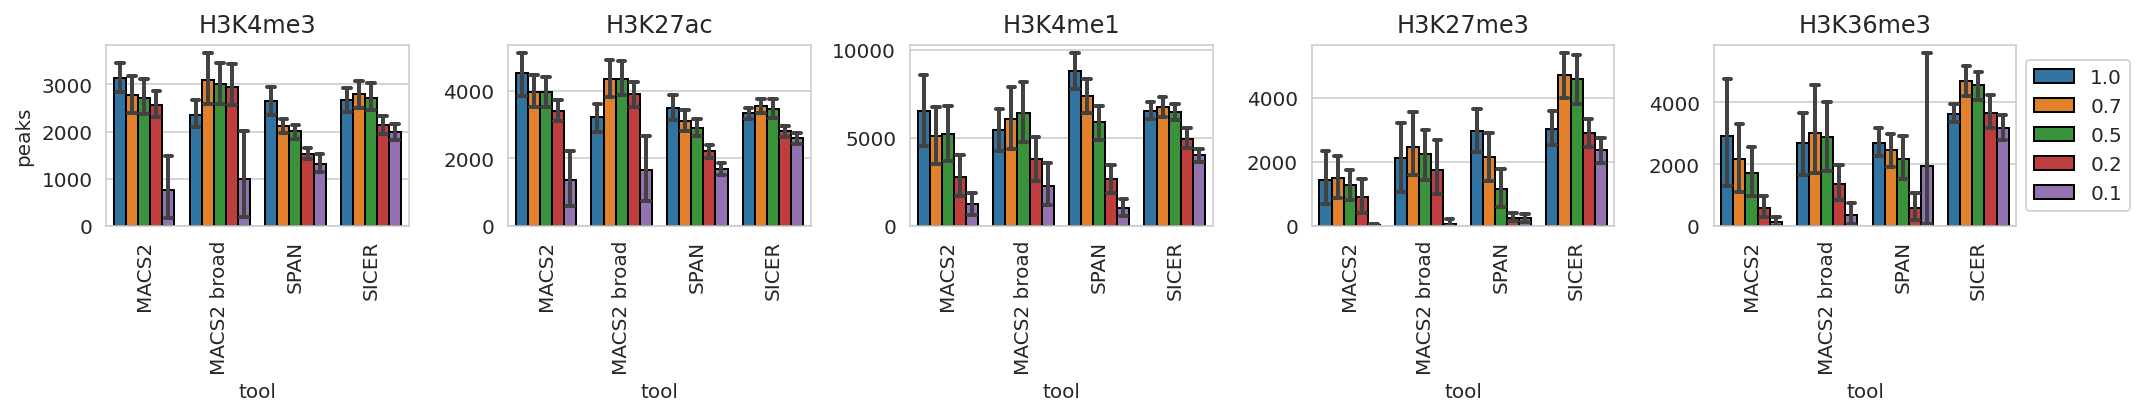

Roadmap


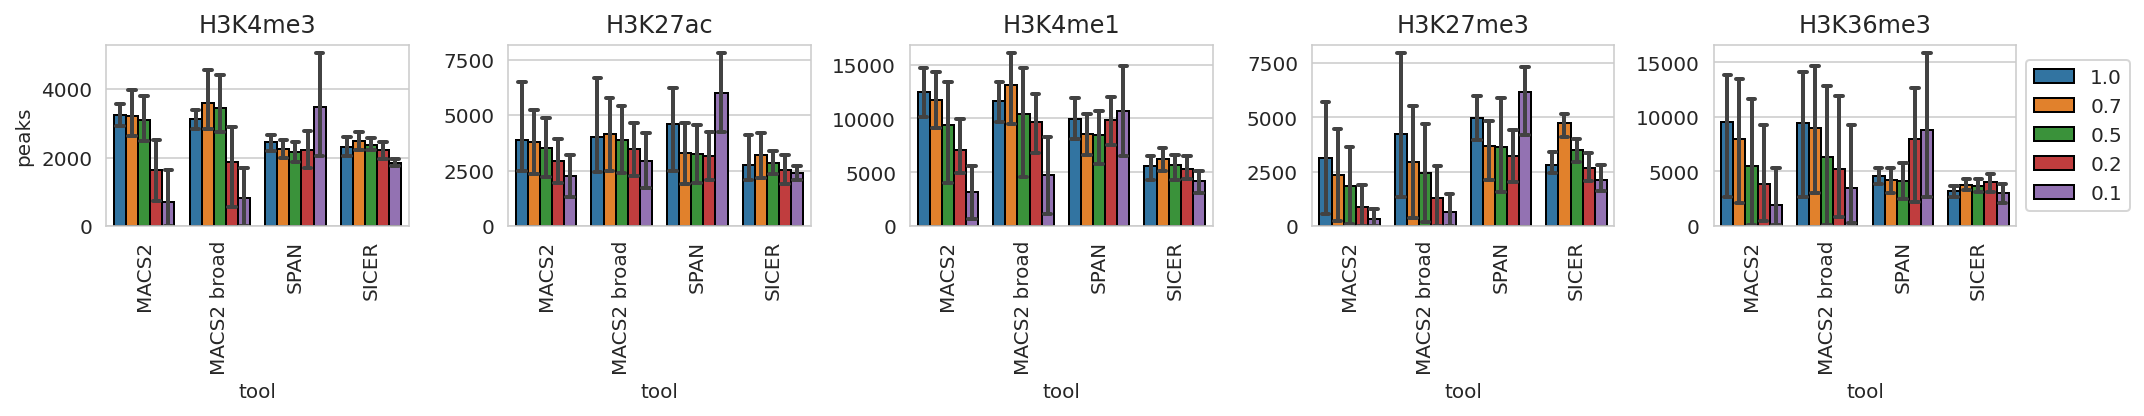

In [135]:
print('Downsampled')
plot_modified(downsampled_peaks_df, 'peaks', False)

Mixed
ENCODE


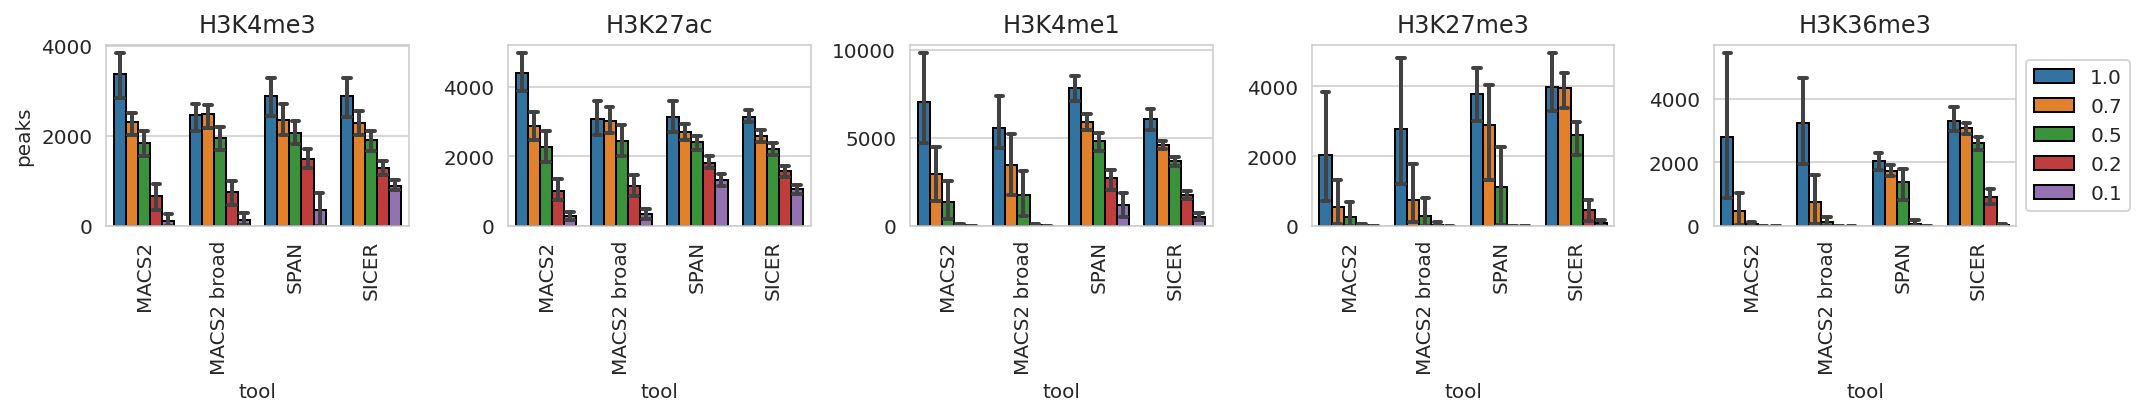

Roadmap


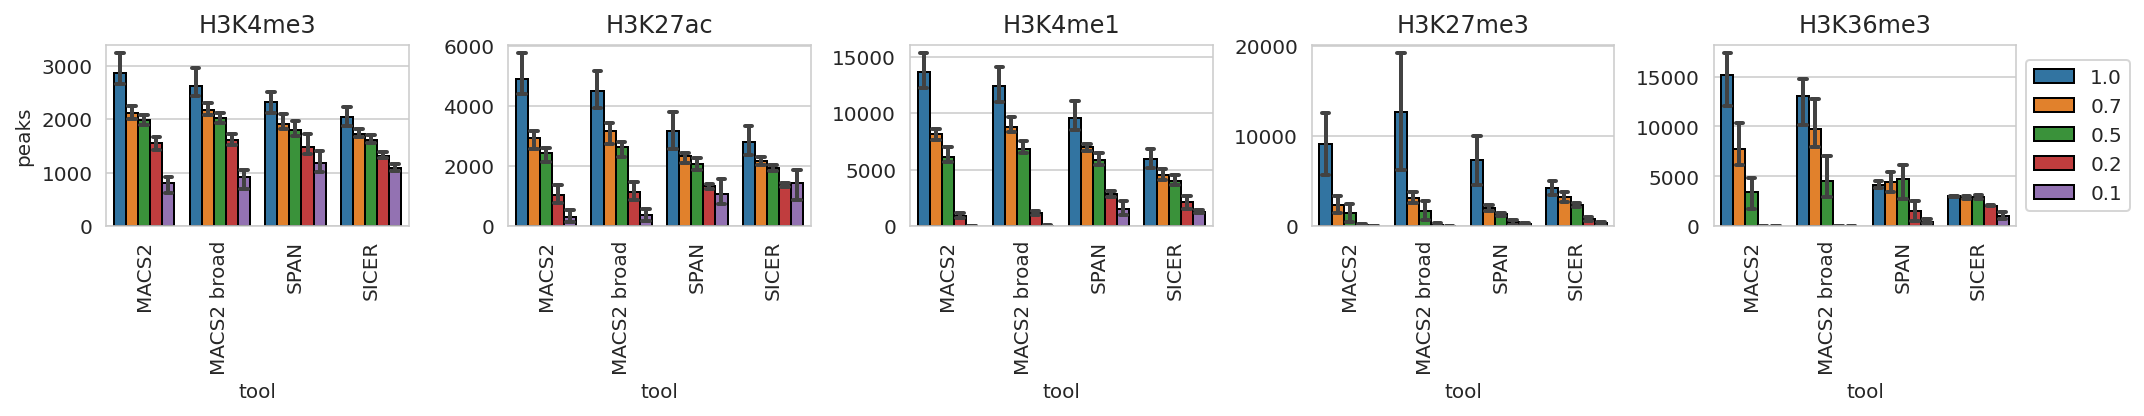

In [166]:
print('Mixed')
plot_modified(mixed_peaks_df, 'peaks', False)

## Jaccard vs original

In [167]:
def overlap_vs_original(df):
    tf = tempfile.mktemp()
    overlaps = []
    for _, (ds, m, c, r, fraction, tool, file) in tqdm(df[df['fraction'] != 1.0][[
        'dataset', 'modification', 'cell', 'replicate', 'fraction', 'tool', 'file'
    ]].iterrows()):
        t = df[(df['fraction'] == 1.0) &
                           (df['dataset'] == ds) &
                           (df['modification'] == m) &
                           (df['cell'] == c) &
                           (df['replicate'] == r) &
                           (df['tool'] == tool)]
        if len(t) == 0:
            print('No original peaks for', ds, m, c, r, tool)
            continue
        original_file = t['file'].values[0]
        original_peaks = lines(original_file)
        original_peaks_len = int(bedl(original_file).sum())
        peaks = lines(file)
        peaks_len = int(bedl(file).sum())
        !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
        original_peaks_overlap = lines(tf)
        !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -a {original_file} -b {file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        overlaps.append((ds, m, c, r, fraction, tool, 
                         peaks, peaks_len, original_peaks, original_peaks_len,
                         peaks_overlap, original_peaks_overlap, overlap_len, 
                         d(overlap_len, peaks_len + original_peaks_len - overlap_len)))
        
    return pd.DataFrame(overlaps, columns=[
        'dataset', 'modification', 'cell', 'replicate', 'fraction', 'tool', 
        'peaks', 'peaks_len', 'original_peaks', 'original_peaks_len',
        'peaks_overlap', 'original_peaks_overlap', 'overlap_len', 'jaccard'
    ])

In [109]:
downsampled_peaks_overlap_df = overlap_vs_original(downsampled_peaks_df)
# Add 1.0 and 0.0 fractions
for _, (ds, m, c, r, t) in list(
        downsampled_peaks_overlap_df[
            ['dataset', 'modification', 'cell', 'replicate', 'tool']].drop_duplicates().iterrows()):
    downsampled_peaks_overlap_df.loc[len(downsampled_peaks_overlap_df)] = \
        [ds, m, c, r, 0.0, t] + [None] * (len(downsampled_peaks_overlap_df.columns) - 7) + [0.0]
    downsampled_peaks_overlap_df.loc[len(downsampled_peaks_overlap_df)] = \
        [ds, m, c, r, 1.0, t] + [None] * (len(downsampled_peaks_overlap_df.columns) - 7) + [1.0]
downsampled_peaks_overlap_df.sample(3)

0it [00:00, ?it/s]

,dataset,modification,cell,replicate,fraction,tool,peaks,peaks_len,original_peaks,original_peaks_len,peaks_overlap,original_peaks_overlap,overlap_len,jaccard
361,Roadmap,H3K4me1,CD34,,0.5,MACS2,13298,10995589,14796,15285840,13027,9969,10733836,0.690386
790,ENCODE,H3K4me3,NHEK,rep2,0.7,SICER,3026,7069374,2910,8126290,2814,2766,6853586,0.821568
1185,ENCODE,H3K36me3,HepG2,rep2,0.1,SPAN,28969,3309539,2786,24000972,18255,2510,2582971,0.104457


In [147]:
from datetime import datetime
now = datetime.now().isoformat(timespec='minutes')
rfile = f'{DOWNSAMPLE_DIR}/downsampled_peaks_overlap_df_{now}.csv.gz'
print(rfile)
downsampled_peaks_overlap_df.to_csv(rfile, compression='gzip', index=None)

/home/jetbrains/data/2023_downsample/downsampled_peaks_overlap_df_2023-11-22T23:51.csv.gz


Downsampled
ENCODE


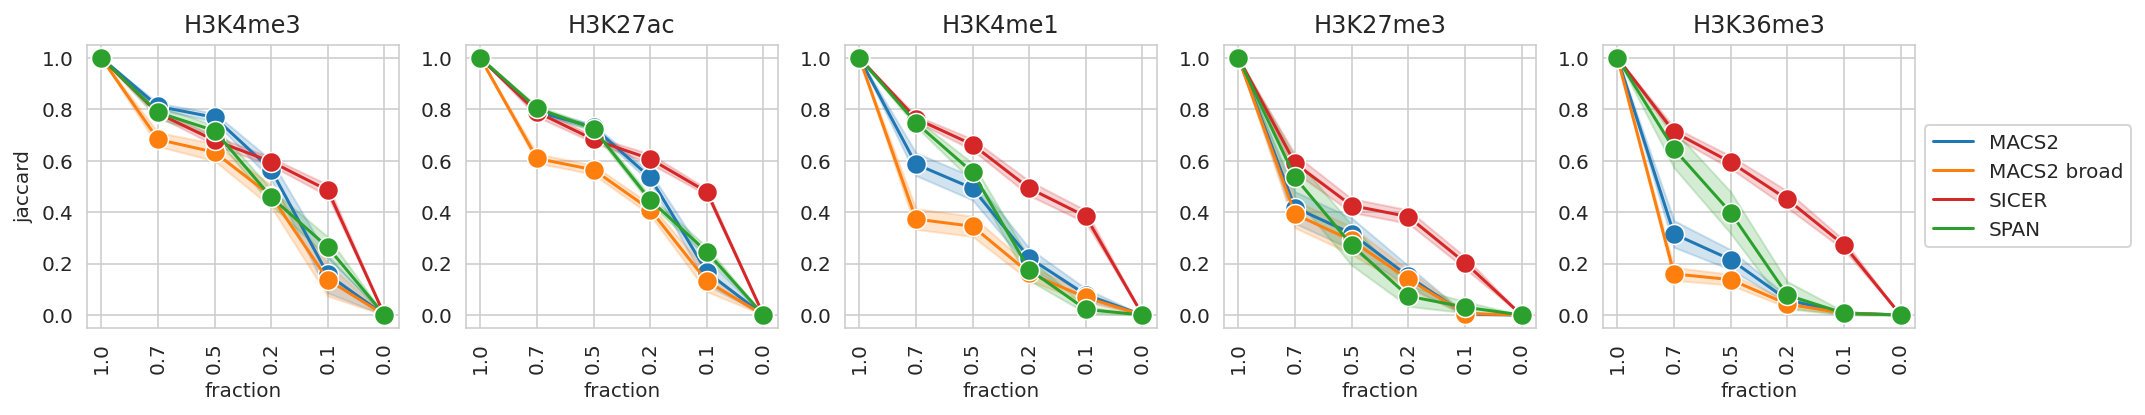

Roadmap


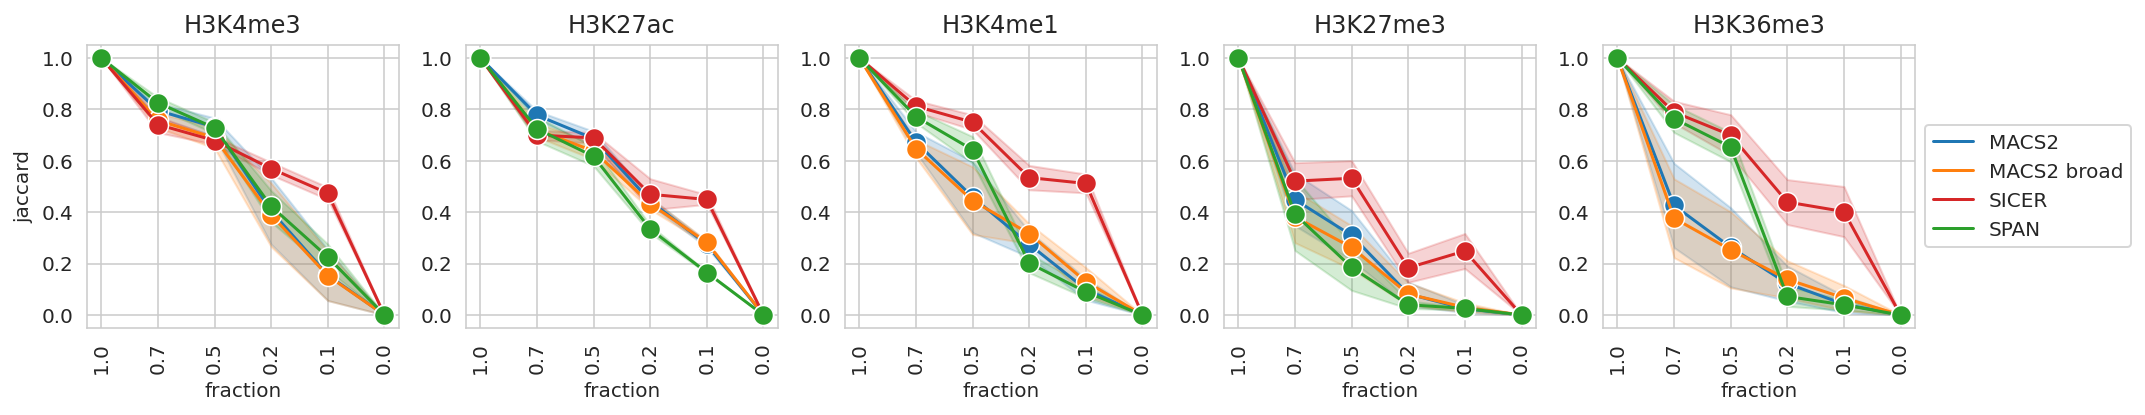

In [140]:
print('Downsampled')
plot_modified(downsampled_peaks_overlap_df, 'jaccard', True)

In [176]:
mixed_peaks_overlap_df = overlap_vs_original(mixed_peaks_df)
# Add 1.0 and 0.0 fraction
for _, (ds, m, c, r, t) in list(
        mixed_peaks_overlap_df[
            ['dataset', 'modification', 'cell', 'replicate', 'tool']].drop_duplicates().iterrows()):
    mixed_peaks_overlap_df.loc[len(mixed_peaks_overlap_df)] = \
        [ds, m, c, r, 0.0, t] + [None] * (len(mixed_peaks_overlap_df.columns) - 7) + [0.0]
    mixed_peaks_overlap_df.loc[len(mixed_peaks_overlap_df)] = \
        [ds, m, c, r, 1.0, t] + [None] * (len(mixed_peaks_overlap_df.columns) - 7) + [1.0]
mixed_peaks_overlap_df.sample(3)

0it [00:00, ?it/s]

,dataset,modification,cell,replicate,fraction,tool,peaks,peaks_len,original_peaks,original_peaks_len,peaks_overlap,original_peaks_overlap,overlap_len,jaccard
682,ENCODE,H3K4me3,K562,rep1,0.1,SPAN,1137,2800198,3492,6575564,1129,1122,2696700,0.403754
88,Roadmap,H3K4me3,TCell,,0.1,MACS2,882,426182,3233,3388606,882,706,425980,0.125702
653,ENCODE,H3K4me1,Huvec,rep1,0.5,SPAN,5117,8321064,7060,11982035,5092,4871,8105040,0.664453


In [179]:
from datetime import datetime
now = datetime.now().isoformat(timespec='minutes')
rfile = f'{MIX_DIR}/mixed_peaks_overlap_df_{now}.csv.gz'
print(rfile)
mixed_peaks_overlap_df.to_csv(rfile, compression='gzip', index=None)

/home/jetbrains/data/2023_mix_10mln/mixed_peaks_overlap_df_2023-11-23T10:44.csv.gz


In [200]:
mixed_peaks_overlap_df = pd.read_csv('~/data/2023_mix/mixed_peaks_overlap_df_2023-11-22T23:50.csv.gz', compression='gzip')
mixed_peaks_overlap_df.sample(3)

,dataset,modification,cell,replicate,fraction,tool,peaks,peaks_len,original_peaks,original_peaks_len,peaks_overlap,original_peaks_overlap,overlap_len,jaccard
2283,ENCODE,H3K4me1,HMEC,rep1,0.0,MACS2 broad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1271,Roadmap,H3K4me3,BCell,NaN,0.2,SICER,1351.0,4143049.0,1864.0,4883136.0,1351.0,1350.0,3226233.0,0.556252
1020,ENCODE,H3K36me3,Huvec,rep1,0.7,SICER,3320.0,13055080.0,3378.0,15845622.0,2971.0,2614.0,11558077.0,0.666455


In [206]:
# print('Mixed control')
# plot_modified(mixed_peaks_overlap_df[mixed_peaks_overlap_df['cell'].isin(
#     ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte'])], 'jaccard', True)

Mixed control
ENCODE


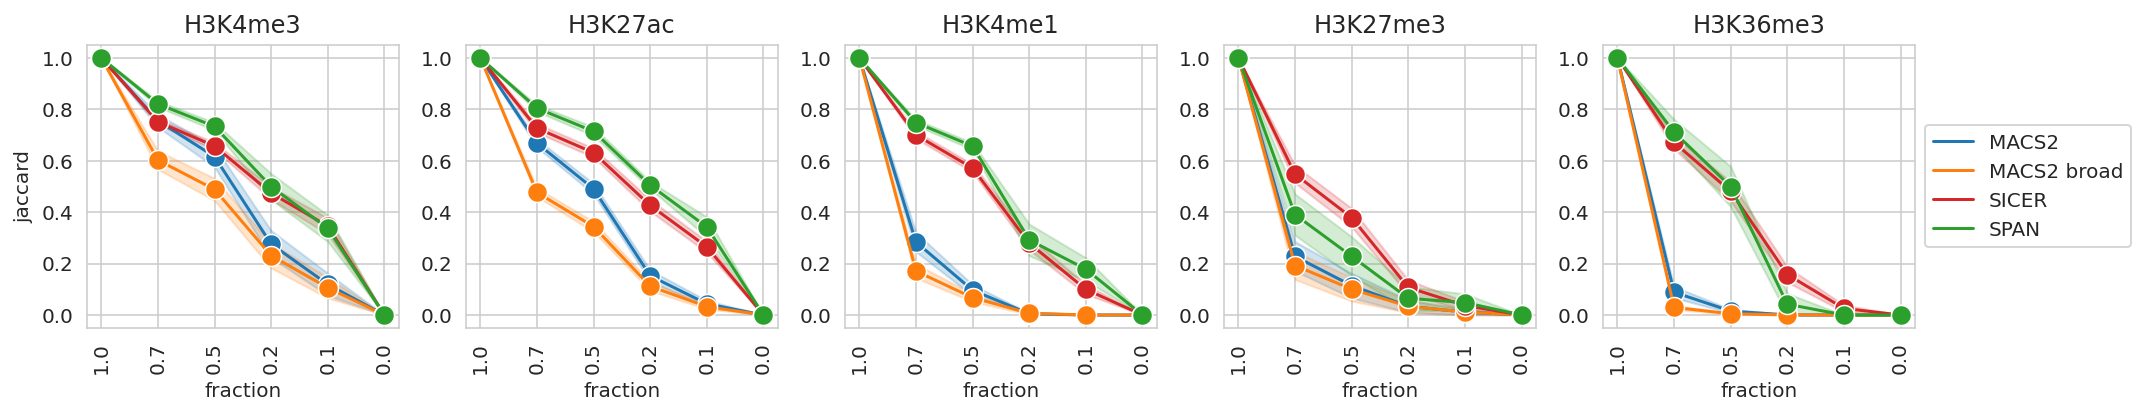

Roadmap


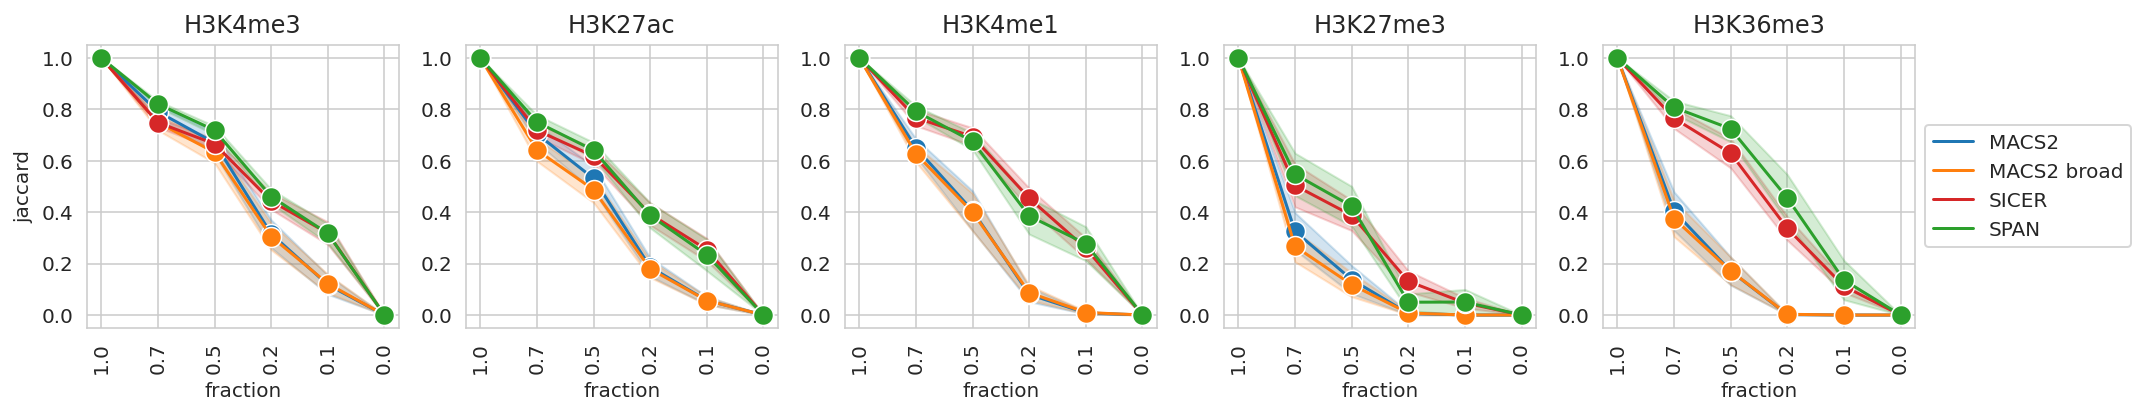

In [207]:
print('Mixed control')
plot_modified(mixed_peaks_overlap_df, 'jaccard', True)

In [250]:
def compute_auc(df, x):
    rows = []
    for (ds, m, c, r, tool), t in df.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
        t = t.copy()
        t.sort_values(by=['fraction'], inplace=True)
        auc = 0
        fraction_prev = 0
        value_prev = 0
        for _, (fraction, value) in t[['fraction', x]].iterrows():
            auc += (fraction - fraction_prev) * (value + value_prev) / 2
            fraction_prev, value_prev = fraction, value
        rows.append((ds, m, c, r, tool, auc))
    return pd.DataFrame(data=rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'auc'])

In [251]:
mixed_peaks_overlap_auc_df = compute_auc(mixed_peaks_overlap_df, 'jaccard')
mixed_peaks_overlap_auc_df.sample(3)

,dataset,modification,cell,replicate,tool,auc
66,ENCODE,H3K27ac,NHLF,rep2,SICER,0.622987
235,ENCODE,H3K4me1,HepG2,rep1,SPAN,0.629799
79,ENCODE,H3K27me3,H1,rep2,SPAN,0.621367


ENCODE


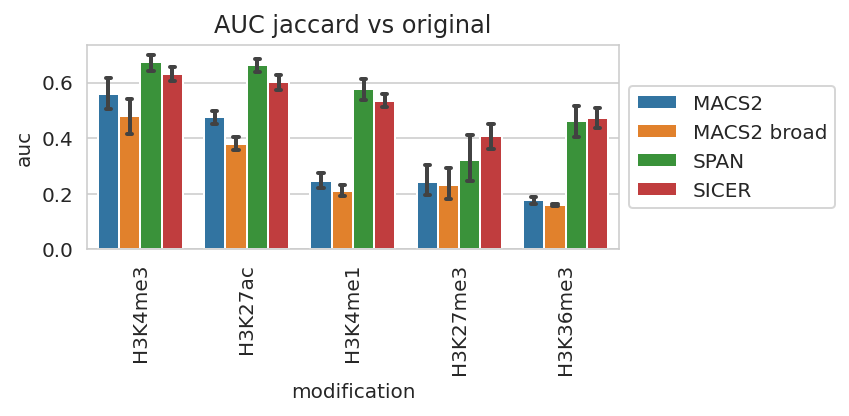

Roadmap


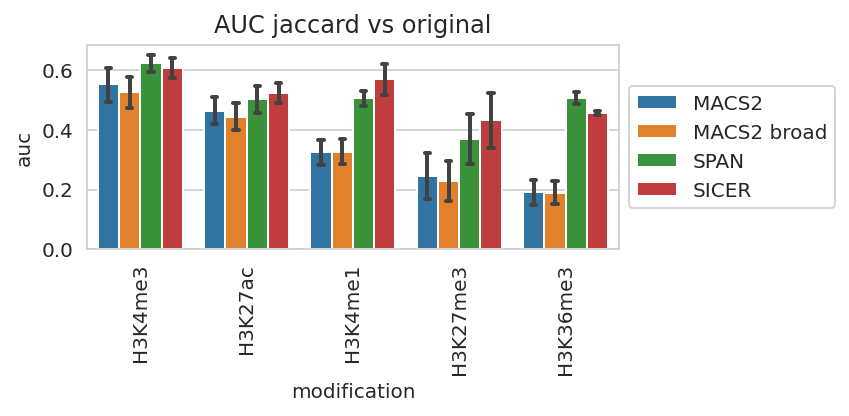

In [252]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 3))
    ax = plt.axes()
    ax.title.set_text('AUC jaccard vs original')
    g_results = sns.barplot(data=mixed_peaks_overlap_auc_df[mixed_peaks_overlap_auc_df['dataset']==ds], 
                            x='modification', y='auc',
                            hue='tool',
                            ax=ax,
                            capsize=.05, errwidth=2,
                            order=MODIFICATIONS,
                            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            )
    ax.xaxis.set_tick_params(rotation=90)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()